# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

def identity(im):
    return im.ravel()

def normalize(img):
    img_max, img_min = np.max(img), np.min(img)
    img = 255.0 *(img - img_min) / (img_max - img_min)
    return img


In [4]:
from cs231n.features import *

num_color_bins = 64 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats   = extract_features(X_val, feature_fns)
X_test_feats  = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7, 1e-6]
regularization_strengths = [1e3, 1e4, 1e5]

results = {}
best_val = -1
best_svm = None

iters = 2000

for rate in learning_rates:
    for strength in regularization_strengths:
        print("learning rate",rate)
        print("regularization strength", strength)
        svm = LinearSVM()
        
        #train it
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength, num_iters=iters, verbose=True, batch_size=200)
        
        y_train_pred = svm.predict(X_train_feats)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val_feats)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_valid = np.mean(y_val == y_val_pred)
        results[(rate, strength)] = (accuracy_train, accuracy_valid)
        
        if best_val < accuracy_valid:
            best_val = accuracy_valid
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate 1e-09
regularization strength 1000.0
iteration 0 / 2000: loss 9.989304
iteration 100 / 2000: loss 9.987634
iteration 200 / 2000: loss 9.964651
iteration 300 / 2000: loss 9.960597
iteration 400 / 2000: loss 9.978413
iteration 500 / 2000: loss 9.963052
iteration 600 / 2000: loss 9.962085
iteration 700 / 2000: loss 9.950573
iteration 800 / 2000: loss 9.946055
iteration 900 / 2000: loss 9.929931
iteration 1000 / 2000: loss 9.935865
iteration 1100 / 2000: loss 9.933332
iteration 1200 / 2000: loss 9.934161
iteration 1300 / 2000: loss 9.941455
iteration 1400 / 2000: loss 9.929917
iteration 1500 / 2000: loss 9.931414
iteration 1600 / 2000: loss 9.920242
iteration 1700 / 2000: loss 9.922303
iteration 1800 / 2000: loss 9.910678
iteration 1900 / 2000: loss 9.929025
training accuracy: 0.112000
validation accuracy: 0.116000
learning rate 1e-09
regularization strength 10000.0
iteration 0 / 2000: loss 19.526010
iteration 100 / 2000: loss 19.224105
iteration 200 / 2000: loss 18.816521
it

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


In [7]:
from cs231n.features import *

num_color_bins = 32 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins), identity]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5, 1e-4, 1e-3]
regularization_strengths = [1e1, 5e1, 1e2]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
iters = 1500

for rate in learning_rates:
    for strength in regularization_strengths:
        print("learning rate",rate)
        print("regularization strength", strength)
        svm = LinearSVM()
        
        #train it
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength, num_iters=iters, verbose=True, batch_size=200)
        
        y_train_pred = svm.predict(X_train_feats)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val_feats)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_valid = np.mean(y_val == y_val_pred)
        results[(rate, strength)] = (accuracy_train, accuracy_valid)
        
        if best_val < accuracy_valid:
            best_val = accuracy_valid
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate 1e-05
regularization strength 10.0
iteration 0 / 1500: loss 9.176096
iteration 100 / 1500: loss 5.388515
iteration 200 / 1500: loss 4.639150
iteration 300 / 1500: loss 5.152587
iteration 400 / 1500: loss 4.907507
iteration 500 / 1500: loss 4.725144
iteration 600 / 1500: loss 4.707501
iteration 700 / 1500: loss 4.926258
iteration 800 / 1500: loss 4.820173
iteration 900 / 1500: loss 4.472194
iteration 1000 / 1500: loss 4.439743
iteration 1100 / 1500: loss 4.558721
iteration 1200 / 1500: loss 4.533654
iteration 1300 / 1500: loss 4.205093
iteration 1400 / 1500: loss 4.451249
training accuracy: 0.455735
validation accuracy: 0.461000
learning rate 1e-05
regularization strength 50.0
iteration 0 / 1500: loss 9.852111
iteration 100 / 1500: loss 6.024930
iteration 200 / 1500: loss 6.052184
iteration 300 / 1500: loss 5.963501
iteration 400 / 1500: loss 5.824924
iteration 500 / 1500: loss 6.121538
iteration 600 / 1500: loss 5.895632
iteration 700 / 1500: loss 6.267640
iteration 800 /

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.434


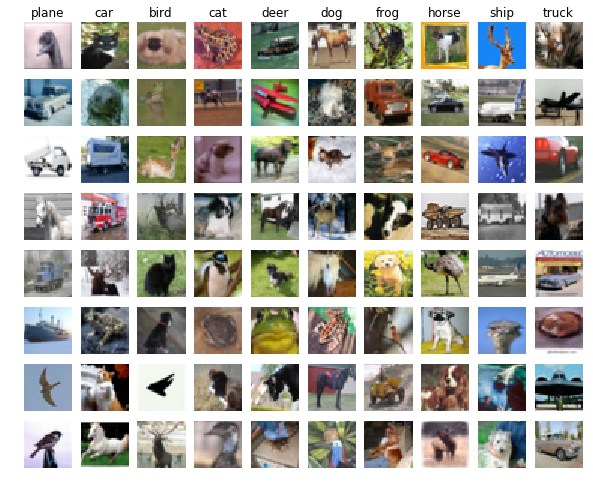

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
The mistakes encountered make sense when we consider input required to create the features. The color histogram feature creates a bias towards images with similar backgrounds or foregrounds as the same class. For example, a deer and other animals photographed against a green/brown background are commonly mis-classified. Similar, the HOG features cause us to put images with similar edges into the same category. The hard edges between car, truck, plane, and ship are quite similar, so the errors make sense.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
print(X_train_feats.shape)

(49000, 3249)


In [12]:
from cs231n.classifiers.neural_net import TwoLayerNet
from copy import deepcopy

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

hidden_size_set = [16, 32, 64, 128, 256, 512]
learning_rate   = [ 5e-2, 3e-2, 1e-2, 1e-3]
learning_rate_decay = [0.99, 0.97, 0.95, 0.90 ]
regularization_strength = [ 0.25, 0.5, 1.0, 1.5]

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
net.train(X_train_feats, y_train, X_val_feats, y_val,
          num_iters=600, batch_size = 200, learning_rate=5e-2,
          learning_rate_decay=0.95, reg=0.0, verbose=True)
best_net = deepcopy(net)
best_acc = (net.predict(X_val_feats) == y_val).mean()

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for hs in hidden_size_set:
    for lr in learning_rate:
        net = TwoLayerNet(input_dim, hs, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=400,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=0.05, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print("hs=%d,lr=%f"%(hs,lr))
        print('Validation accuracy: ', val_acc)
        #print(net.best_val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = deepcopy(net)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 600: loss 2.302586
iteration 100 / 600: loss 1.561647
iteration 200 / 600: loss 1.515641
iteration 300 / 600: loss 1.294278
iteration 400 / 600: loss 1.509375
iteration 500 / 600: loss 1.284358
iteration 0 / 1000: loss 2.302598
iteration 100 / 1000: loss 1.723069
iteration 200 / 1000: loss 1.690131
iteration 300 / 1000: loss 1.607600
iteration 400 / 1000: loss 1.739769
iteration 500 / 1000: loss 1.725992
iteration 600 / 1000: loss 1.603087
iteration 700 / 1000: loss 1.692690
iteration 800 / 1000: loss 1.677532
iteration 900 / 1000: loss 1.727958
hs=16,lr=0.050000
Validation accuracy:  0.498
iteration 0 / 1000: loss 2.302598
iteration 100 / 1000: loss 1.773934
iteration 200 / 1000: loss 1.764549
iteration 300 / 1000: loss 1.588438
iteration 400 / 1000: loss 1.665491
iteration 500 / 1000: loss 1.619871
iteration 600 / 1000: loss 1.661321
iteration 700 / 1000: loss 1.603354
iteration 800 / 1000: loss 1.586687
iteration 900 / 1000: loss 1.625600
hs=16,lr=0.030000
Validation a

In [13]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.554


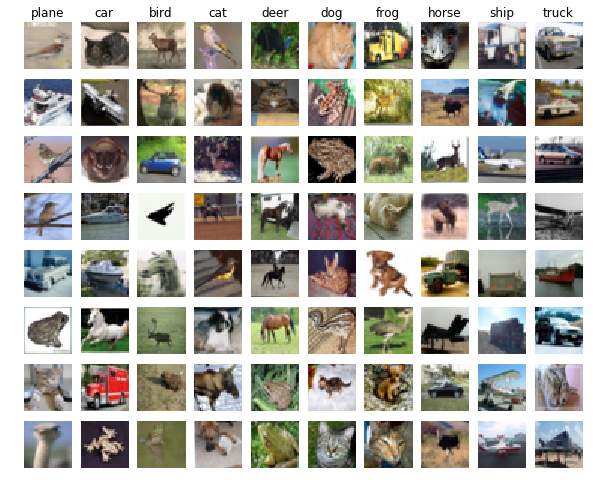

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [15]:
"""Compute the difference of Gaussian Filter feature for an image
     
        Uses scipy.ndimage.filters.gaussian_filter;

      Parameters:
        im : an input grayscale or rgb image
        i  : size of the standard deviation of the first gaussian_filter
        j  : size of the standard deviation of the second gaussian_filter

      Returns:
        feat: DoG 
  """
def dog_ij_feature(im,i=1,j=3,order=0):
    if i == j:
        raise ValueError("i=%d must not be equal to j=%d" % (i,j))

    from scipy.ndimage.filters import gaussian_filter
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.atleast_2d(im)
    sx, sy = image.shape # image size
    image_gaussian_i = gaussian_filter(image, sigma=i, order=order, mode='reflect', truncate=3.0)
    image_gaussian_j = gaussian_filter(image, sigma=j, order=order, mode='reflect', truncate=3.0)
    
    return (np.abs(image_gaussian_i - image_gaussian_j)/np.max(image_gaussian_i - image_gaussian_j)).ravel()

In [16]:
def sobel_feature(im, axis=-1):
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)
    from scipy.ndimage.filters import sobel
    return sobel(image, axis=axis).ravel()

(-0.5, 31.5, 31.5, -0.5)

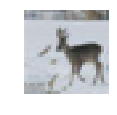

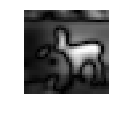

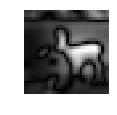

In [17]:
plt.figure(figsize=(1.5,1.5,))
plt.imshow(X_train[20].astype('uint8'))
plt.axis('off')
plt.figure(figsize=(1.5,1.5,))
plt.imshow(dog_ij_feature(X_train[20],1.,5,0).reshape(32,32).astype(np.float32))
plt.axis('off')
plt.figure(figsize=(1.5,1.5,))
test_image = dog_ij_feature(X_train[20],1,5,0)
#test_image[test_image < 0.75] = 0
plt.imshow(normalize(test_image).reshape(32,32).astype('uint8'))
plt.axis('off')


(32, 0)

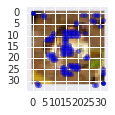

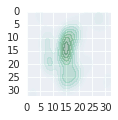

In [18]:
import seaborn as sns

def dog_ij_feature_threshold(im, i=1, j=3, order=0, threshold=0.5):
    if i == j:
        raise ValueError("i=%d must not be equal to j=%d" % (i,j))

    from scipy.ndimage.filters import gaussian_filter
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.atleast_2d(im)
    sx, sy = image.shape # image size
    image_gaussian_i = gaussian_filter(image, sigma=i, order=order, mode='reflect', truncate=3.0)
    image_gaussian_j = gaussian_filter(image, sigma=j, order=order, mode='reflect', truncate=3.0)
    
    dog = (np.abs(image_gaussian_i - image_gaussian_j)/np.max(image_gaussian_i - image_gaussian_j)).ravel()
    mean     = np.mean(dog)
    std_dev  = np.std(dog)
    dog[dog < mean - std_dev * threshold] = 0
    return dog


def dog_ij_top_n_pixels(im, i=1, j=3, order=0, n_pixels = 20):
    idx = im.argsort()[-n_pixels:]    
    return idx

#NOT SURE ABOUT ORIENTATION
n_pixels = dog_ij_top_n_pixels(dog_ij_feature(X_train[0],1,3,0),n_pixels = 120)
#print(np.mean(np.unravel_index(list(n_pixels),(32,32)),axis=1))
#print(np.std(np.unravel_index(list(n_pixels),(32,32)),axis=1))

#print(np.unravel_index(list(n_pixels),(32,32)))
x = np.unravel_index(list(n_pixels),(32,32))[0] 
y = np.unravel_index(list(n_pixels),(32,32))[1]
#x = 32 - x
y = 32 - y


#have to flip the y axis because of the origin location
# sns.distplot(x, hist=False, rug=True, kde_kws = {"bw" :1.0})
# sns.distplot(y, hist=False, rug=True, kde_kws = {"bw" :1.0})

# plt.figure()
# sns.jointplot(x, y, kind="kde", size=7, space=0)

plt.figure(figsize=(1.5,1.5))
plt.imshow(X_train[0].astype('uint8'),origin="upper")
plt.scatter(x,y, alpha=0.5)
plt.scatter([0],[0])
plt.scatter([31],[31])

plt.figure(figsize=(1.5,1.5))
sns.kdeplot(x,y, shade=True,alpha=0.3)
plt.xlim([0,32])
plt.ylim([32,0])



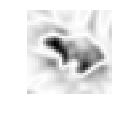

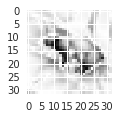

In [19]:
plt.figure(figsize=(1.5,1.5,))
plt.axis('off')
plt.imshow(dog_ij_feature(X_train[21],1,5,0).reshape(32,32))
#test_image = dog_ij_feature_threshold(X_train[20],1,5,0,0.5)
#test_image[test_image < 0.75] = 0
plt.figure(figsize=(1.5,1.5))
plt.imshow(normalize(dog_ij_feature(X_train[21],0.1,5,0).reshape(32,32)).astype('uint8'))

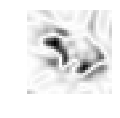

In [20]:
plt.figure(figsize=(1.5,1.5,))
plt.axis('off')
plt.imshow(normalize(dog_ij_feature(X_train[21],1,3,0)).reshape(32,32).astype('uint8'))

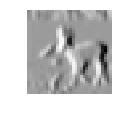

In [21]:
plt.figure(figsize=(1.5,1.5,))
plt.axis('off')
plt.imshow(sobel_feature(X_train[20]).reshape(32,32))

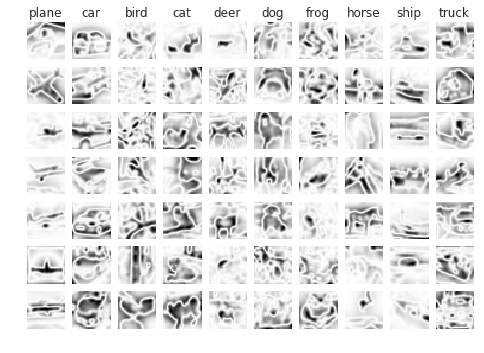

In [22]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(normalize(dog_ij_feature(X_train[idx],i=1,j=5,order=0).reshape(32,32)).astype(np.uint8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

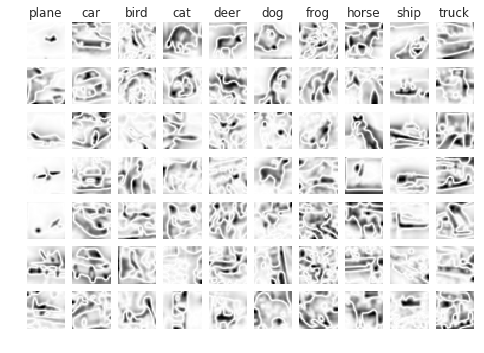

In [23]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        transformed_image = normalize(dog_ij_feature(X_train[idx],i=1,j=5,order=0)).astype(np.uint8)
        plt.imshow(transformed_image.reshape(32,32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

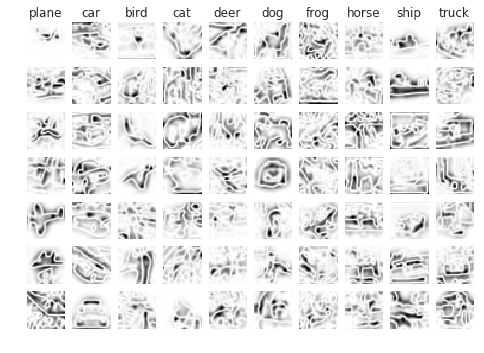

In [24]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        transformed_image = normalize(dog_ij_feature(X_train[idx],i=1,j=3,order=0)).astype(np.uint8)
        transformed_image[transformed_image < np.mean(transformed_image) - np.std(transformed_image)] = 0
        plt.imshow(transformed_image.reshape(32,32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

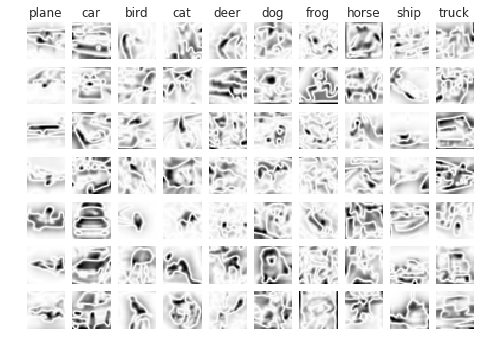

In [25]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(dog_ij_feature(X_train[idx].astype('uint8'),i=1,j=5,order=0).reshape(32,32).astype(np.float32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

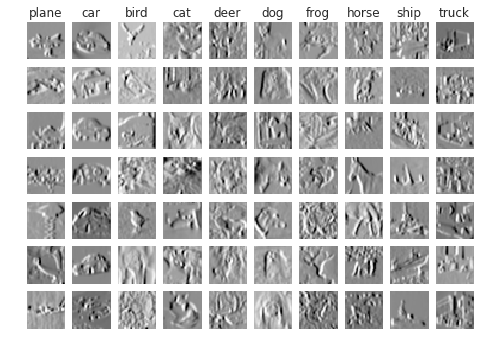

In [26]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(sobel_feature(X_train[idx].astype('uint8')).reshape(32,32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [27]:
def generate_idx(image, count = 64):
    size = len(image.ravel())
    mask = np.random.random_integers(0, size, count)
    return mask

def sample_image(image, idx):
    return image[idx]

def single_color_image(im, color=0):
    if im.ndim != 3:
        raise ValueError("Invalid input image. Expected a numpy array with dim 3 (bgr).")
    if color < 0 or color > 3:
        raise ValueError("Color should be 0,1,2 (red, green, blue)")
    return im[:,:,color].ravel()

def single_channel_image(im, color=0):
    if im.ndim != 3:
        raise ValueError("Invalid input image. Expected a numpy array with dim 3 (bgr).")
    if color < 0 or color > 3:
        raise ValueError("Color should be 0,1,2 (red, green, blue)")
    channel_reduced = np.zeros(im.shape)
    channel_reduced[:,:,color] = single_color_image(im, color).reshape((im.shape[0],im.shape[1]))
    #return the image back in the same 3-dim format
    return channel_reduced

def patch_ravel(img, size=3):
    from sklearn.feature_extraction import image
    patches = image.extract_patches_2d(img, (size,size))
    list_of_patches = []
    for r in patches:
        list_of_patches.append(r.reshape(-1))
    return np.array(list_of_patches).ravel()

for x in list(range(2,30)):
    p = patch_ravel(X_train[1], x)
    print(p.shape)
    del p
    
#shape is (number of windows) x (3 * size * size)
#dimensionality of patch_ravel is too big for this laptop

(11532,)
(24300,)
(40368,)
(58800,)
(78732,)
(99372,)
(120000,)
(139968,)
(158700,)
(175692,)
(190512,)
(202800,)
(212268,)
(218700,)
(221952,)
(221952,)
(218700,)
(212268,)
(202800,)
(190512,)
(175692,)
(158700,)
(139968,)
(120000,)
(99372,)
(78732,)
(58800,)
(40368,)


In [28]:
feature_fns = [hog_feature,
               lambda img: color_histogram_hsv(img, nbin=num_color_bins),
               lambda image:  dog_ij_feature(image)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats   = extract_features(X_val, feature_fns)
X_test_feats  = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])


Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [29]:
from cs231n.classifiers.neural_net import TwoLayerNet
from copy import deepcopy

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

hidden_size_set = [16, 32, 64, 128, 256, 512]
learning_rate   = [ 5e-2, 3e-2, 1e-2, 1e-3]
learning_rate_decay = [0.99, 0.97, 0.95, 0.90 ]
regularization_strength = [ 0.25, 0.5, 1.0, 1.5]

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
net.train(X_train_feats, y_train, X_val_feats, y_val,
          num_iters=600, batch_size = 200, learning_rate=1e-2,
          learning_rate_decay=0.95, reg=0.0, verbose=True)
best_net = deepcopy(net)
best_acc = (net.predict(X_val_feats) == y_val).mean()


iteration 0 / 600: loss 2.302585
iteration 100 / 600: loss 2.286353
iteration 200 / 600: loss 1.984234
iteration 300 / 600: loss 1.643025
iteration 400 / 600: loss 1.492933
iteration 500 / 600: loss 1.243493


1.44047579115 0.199162101098
1.04409898183 0.153247713517
1.0 0.141113486523


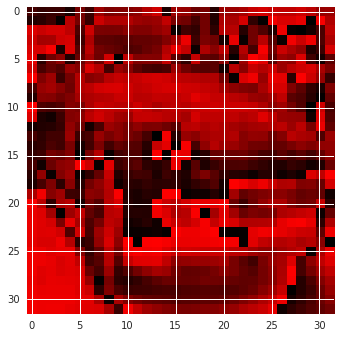

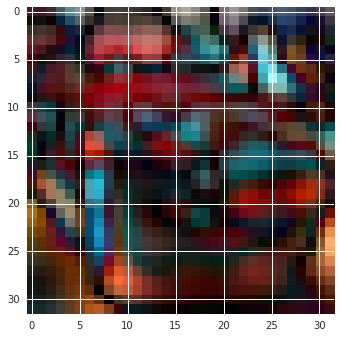

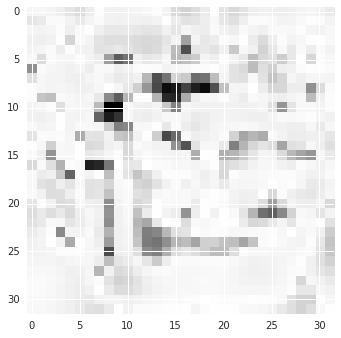

In [30]:

test = np.zeros(X_train[5].shape)
test = single_channel_image(X_train[5],0)


plt.imshow(normalize(test.astype('uint8')))


#plt.imshow(normalize(X_train[5]).reshape(32,32,3).astype('uint8'))

# plt.figure()
# plt.imshow(dog_ij_feature(single_channel_image(X_train[5],0)).reshape(32,32))
# plt.figure()
# plt.imshow(dog_ij_feature(single_channel_image(X_train[5],1)).reshape(32,32))
# plt.figure()
# plt.imshow(dog_ij_feature(single_channel_image(X_train[5],2)).reshape(32,32))

plt.figure()
channel_isolated_DOG = np.zeros(X_train[5].shape)
channel_isolated_DOG[:,:,0] = dog_ij_feature(single_channel_image(X_train[5],0),1,3).reshape(32,32)
channel_isolated_DOG[:,:,1] = dog_ij_feature(single_channel_image(X_train[5],1),1,3).reshape(32,32)
channel_isolated_DOG[:,:,2] = dog_ij_feature(single_channel_image(X_train[5],2),1,3).reshape(32,32)
plt.imshow(channel_isolated_DOG)

plt.figure()
gray_isolated_DOG = rgb2gray(channel_isolated_DOG)
plt.imshow(np.abs(gray_isolated_DOG - dog_ij_feature(X_train[5]).reshape(32,32)))


single_channel_dog = dict()
for k in range(3):
    single_channel_dog[k] = dog_ij_feature(single_channel_image(X_train[5],k),i=1,j=3,order=1)

for k in range(3):
    print(np.max(single_channel_dog[k]),np.mean(single_channel_dog[k]))


In [31]:
num_color_bins = 128 # Number of bins in the color histogram

feature_fns = [hog_feature,
               lambda img: color_histogram_hsv(img, nbin=num_color_bins),
               lambda image:  dog_ij_feature(image), 
               identity]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats   = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats  = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

iteration 0 / 5000: loss 19.977556
iteration 100 / 5000: loss 9.341001
iteration 200 / 5000: loss 7.076085
iteration 300 / 5000: loss 7.528066
iteration 400 / 5000: loss 7.404254
iteration 500 / 5000: loss 7.551784
iteration 600 / 5000: loss 7.136035
iteration 700 / 5000: loss 7.510185
iteration 800 / 5000: loss 7.438042
iteration 900 / 5000: loss 7.639685
iteration 1000 / 5000: loss 7.055679
iteration 1100 / 5000: loss 7.238532
iteration 1200 / 5000: loss 7.666061
iteration 1300 / 5000: loss 7.689167
iteration 1400 / 5000: loss 7.153046
iteration 1500 / 5000: loss 7.507895
iteration 1600 / 5000: loss 7.908323
iteration 1700 / 5000: loss 7.298371
iteration 1800 / 5000: loss 7.404765
iteration 1900 / 5000: loss 7.658136
iteration 2000 / 5000: loss 7.543328
iteration 2100 / 5000: loss 7.350306
iteration 2200 / 5000: loss 7.018929
iteration 2300 / 5000: loss 7.224807
iteration 2400 / 5000: loss 7.682682
iteration 2500 / 5000: loss 7.466902
iteration 2600 / 5000: loss 7.505914
iteration 27

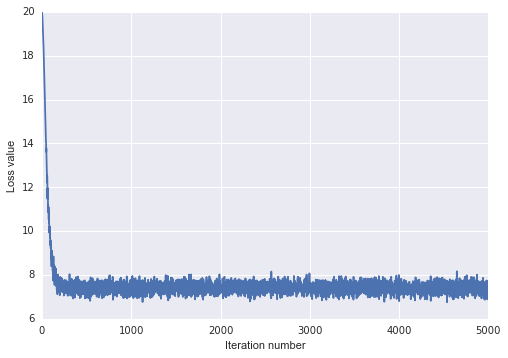

In [32]:
from cs231n.classifiers import LinearSVM
import time
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train_feats, y_train, learning_rate=1e-6, reg=5e2, num_iters=5000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [33]:
y_test_pred = svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.336


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!